<a href="https://colab.research.google.com/github/arjunsinghrathore/ARSAVEWILDLIFE/blob/master/Advanced_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALBERT(from HuggingFace Transformers) for Text Extraction

The abstract from the paper is the following:

Increasing model size when pretraining natural language representations often results in improved performance on downstream tasks. However, at some point further model increases become harder due to GPU/TPU memory limitations, longer training times, and unexpected model degradation. To address these problems, we present two parameter-reduction techniques to lower memory consumption and increase the training speed of BERT. Comprehensive empirical evidence shows that our proposed methods lead to models that scale much better compared to the original BERT. We also use a self-supervised loss that focuses on modeling inter-sentence coherence, and show it consistently helps downstream tasks with multi-sentence inputs. As a result, our best model establishes new state-of-the-art results on the GLUE, RACE, and SQuAD benchmarks while having fewer parameters compared to BERT-large.

It basically presents two parameter-reduction techniques to lower memory consumption and increase the training speed of BERT:
1. Splitting the embedding matrix into two smaller matrices.
2. Using repeating layers split among groups.

However the computational cost remains similar to a BERT-like architecture with the same number of hidden layers as it has to iterate through the same number of (repeating) layers.

## Introduction to Dataset & Training Method

The model was first fine-tuned with Stanford Question-Answering Dataset(SQuAD).
In SQuAD, an input consists of a question, and a paragraph for context.
The goal is to find the span of text in the paragraph that answers the question.
We evaluate our performance on this data with the "Exact Match" metric,
which measures the percentage of predictions that exactly match any one of the
ground-truth answers.

We fine-tune a ALBERT model to perform this task as follows:

1. Feed the context and the question as inputs to ALBERT.
2. Take two vectors S and T with dimensions equal to that of
   hidden states in ALBERT.
3. Compute the probability of each token being the start and end of
   the answer span. The probability of a token being the start of
   the answer is given by a dot product between S and the representation
   of the token in the last layer of ALBERT, followed by a softmax over all tokens.
   The probability of a token being the end of the answer is computed
   similarly with the vector T.
4. Fine-tune ALBERT and learn S and T along the way.

**References:**

- [ALBERT](https://arxiv.org/abs/1909.11942)
- [SQuAD](https://arxiv.org/abs/1606.05250)


## Setup


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install tokenizers
!pip install transformers
!pip install sentence-transformers
!pip install sentencepiece
!pip install datasets

     |████████████████████████████████| 3.3MB 6.6MB/s 
     |████████████████████████████████| 2.3MB 7.1MB/s 
     |████████████████████████████████| 901kB 27.2MB/s 
     |████████████████████████████████| 81kB 4.3MB/s 
     |████████████████████████████████| 1.2MB 8.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=5433a1c636c571ee0ad0f24e6bb2e143f048ae74a9175b7ca4eada88c5d02419
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers
     |████████████████████████████████| 235kB 5.4MB/s 
     |████████████████████████████████| 245kB 8.2MB/s 
     |████████████████████████████████| 112kB 10.2MB/s 


In [4]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import AlbertTokenizerFast, TFAlbertModel, AlbertConfig
import sentencepiece
from tqdm import tqdm
import pandas as pd
from sentence_transformers import CrossEncoder
from transformers import T5TokenizerFast, T5Config, TFT5Model
from datasets import load_dataset
import datasets


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Fine Tuning on Squad**

In [6]:
configuration = AlbertConfig()  # default parameters and configuration for ALBERT

## Load the Data & Tokenizer


The data is downloaded first by using the  JSON path

In [7]:
train_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)


4857856/4854279 [==============================] - 0s 0us/step


In [8]:
# The tokenizer is loaded, we used the fast tokenizer from huggingface
tokenizer = AlbertTokenizerFast.from_pretrained('albert-large-v2')

## Preprocess the data

1. Go through the JSON file and store every record as a SquadExample object.
2. Go through each SquadExample and create x_train, y_train, x_eval, y_eval.


In [9]:
max_len = 384 # The maximum length is set as 384

In [ ]:
# SquadExample class is used for making an object for each question in SQuAD
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text, all_answers):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer(context, return_offsets_mapping=True)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, start_end in enumerate(tokenized_context['offset_mapping']):
            start = start_end[0]
            end = start_end[1]
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer(question, return_offsets_mapping=True)

        # Create inputs
        input_ids = tokenized_context['input_ids'] + tokenized_question['input_ids'][1:]
        token_type_ids = [0] * len(tokenized_context['input_ids']) + [1] * len(
            tokenized_question['input_ids'][1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context['offset_mapping']

# Training & Validation Data is Loaded
with open(train_path) as f:
    raw_train_data = json.load(f)

with open(eval_path) as f:
    raw_eval_data = json.load(f)


def create_squad_examples(raw_data):
    squad_examples = []
    for item in tqdm(raw_data["data"]):
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer_text = qa["answers"][0]["text"]
                all_answers = [_["text"] for _ in qa["answers"]]
                start_char_idx = qa["answers"][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text, all_answers
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y


train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")


 57%|█████▋    | 254/442 [00:52<00:39,  4.77it/s]

## **Model Maker** 

Create the Question-Answering Model using BERT and Functional API


In [ ]:

def create_model():
    ## Pretrained ALBERT encoder
    encoder = TFAlbertModel.from_pretrained("albert-large-v2")

    ## QA Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    # Getting the Contextual EMbeddings from ALBERT
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]

    # Making a model for using the embeddings trained on SQuAD QA when fine-tuning on UNIV-AI1 QA Data
    embedding_model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=embedding,
    )

    # embedding_model.load_weights('/content/drive/MyDrive/univai/Project/squad_model.h5')

    # The probability for identifying the start index of the attention span
    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
    start_logits = layers.Flatten()(start_logits)

    # The probability for identifying the end index of the attention span
    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
    end_logits = layers.Flatten()(end_logits)

    # Softmax is applied for getting the probabilities
    start_probs = layers.Activation(keras.activations.softmax)(start_logits)
    end_probs = layers.Activation(keras.activations.softmax)(end_logits)

    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[start_probs, end_probs],
    )
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss=[loss, loss], metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')])
    return model, embedding_model



We advise this notebook to be run on Google Colab TPU runtime.
With Colab TPUs, each epoch will take 10 minutes.


In [ ]:
use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model, embedding_model = create_model()
else:
    model, embedding_model = create_model()

In [ ]:
model.summary()

## Create evaluation Callback

This callback will compute the exact match score & F1 score using the validation data
after every epoch.


In [ ]:
from collections import Counter
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score_fn(prediction_tokens, ground_truth_tokens):
    # prediction_tokens = normalize_answer(prediction).split()
    # ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Iterating over each possible answer and finding if any of our predictions match
def intermediate_for_f1(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)

class ExactMatch(keras.callbacks.Callback):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        f1_score = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalize_text(pred_ans)
            normalized_true_ans = [normalize_text(_) for _ in squad_eg.all_answers]
            f1_score += intermediate_for_f1(f1_score_fn, normalized_pred_ans, normalized_true_ans)
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        f1_score = f1_score / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}, f1 score={f1_score:.2f}")



## Train and Evaluate


In [ ]:
exact_match_callback = ExactMatch(x_eval, y_eval)
model.fit(
    x_train,
    y_train,
    epochs=3,  # For demonstration, 3 epochs are recommended
    verbose=1,
    batch_size=64,
    callbacks=[exact_match_callback],
)


In [16]:
embedding_model.save_weights('/content/drive/MyDrive/univai/Project/squad_model.h5')

In [17]:
model.save_weights('/content/drive/MyDrive/univai/Project/squad_whole_model.h5')

# **Fine Tuning on UNIV AI Dataset With Manually Added Context**





1. For fine-tuning the ALBERT model on the small UNIV-AI dataset we'll be initializing the weights for the ALBERT embeddings from the above trained SQuAD model and freeze them, only the dense layer for getting the probabilities of start and end token is trained.
2. The context for each question was mapped manually for this section, an automated method will be dsicussed in the coming sections

In [ ]:
configuration = AlbertConfig()  # default parameters and configuration for ALBERT

## Load the Data & Tokenizer


In [5]:
# Your code here
def clean_data(data):
    message_list = data
    for i in range(len(message_list)):
        # Lower Case
        message = message_list[i].lower()

        message = " ".join([word for word in message.split() if word.find('yes') == -1])
        message = " ".join([word for word in message.split() if word.find('no') == -1])
        
        message = " ".join(message.split())

        message_list[i] = message

    return message_list

In [6]:
# Loading the training data including the manually added context
df_con = pd.read_csv('/content/drive/MyDrive/univai/Project/faq_context.csv')

In [7]:
df_con.head()

,Unnamed: 0,Title,Context,Question,Answer,Unnamed: 2,Unnamed: 3
0,0,Pre-class,The course schedule may include readings in th...,Are session pre-class quizzes graded?,No. Pre-class quiz is to just check your under...,NaN,NaN
1,1,Deadlines,The exercises that you worked on during the ma...,When is the deadline for the submission of ses...,5 PM on the day of the following lecture.,NaN,NaN
2,2,Deadlines,The exercises that you worked on during the ma...,Will there be any extension allowed for the qu...,Only for exceptional cases.,NaN,NaN
3,3,Amount of work,Our courses need a time commitment of about 15...,How many hours will I need to dedicate to succ...,About 15 hours per week.,NaN,NaN
4,4,Exercise grading,We conduct both group and individual evaluatio...,Who will grade my exercise?,The exercises are auto-graded once you click t...,NaN,NaN


In [8]:
# Getting the Context, Question & Answer in a list. Then cleaning them
questions_list = df_con.Question.tolist()
clean_questions = clean_data(questions_list)

answer_list = df_con.Answer.tolist()
clean_answers = clean_data(answer_list)

context_list = df_con.Context.tolist()
clean_context = clean_data(context_list)

In [11]:
# Finding the start index for the answer in the context, if not found ind is set at 0
start_indexes = []
for context, answer in zip(clean_context, clean_answers):
  ind = context.find(answer[:20])
  if ind == -1:
    ind = context.find(answer[:5])
  if ind == -1:
    ind = 0
  start_indexes.append(ind)

In [12]:
# Loading the test dataset with the manually added context
df_test = pd.read_csv('/content/drive/MyDrive/univai/Project/test_manual.csv')

In [13]:
df_test.head()

,Questions,Context,start_idx,end_idx
0,Will the pre-class session be recorded?,The course schedule may include readings in th...,0,2
1,What is the deadline for quiz submission?,The exercises that you worked on during the ma...,0,2
2,What is the deadline for exercise submission?,The exercises that you worked on during the ma...,0,2
3,How many hours do I need to complete this course?,Our courses need a time commitment of about 15...,0,2
4,Who will grade the exercise?,We conduct both group and individual evaluatio...,0,2


In [14]:
# Getting the Context, Question & Answer in a list. Then cleaning them
val_questions = df_test.Questions.tolist()
val_questions = clean_data(val_questions)

val_answers = ['No Provided Answer']*len(val_questions) # Dummy Answer for ease of uniform preprocessing

val_context = df_test.Context.tolist()
val_context = clean_data(val_context)

# Dummy start_idx for ease of uniform preprocessing
val_start_idx = df_test.start_idx.tolist()

In [15]:
# Tokenizer is loaded
tokenizer = AlbertTokenizerFast.from_pretrained('albert-large-v2')

## Preprocess the data

1. Go through the JSON file and store every record as a SquadExample object.
2. Go through each SquadExample and create x_train, y_train, x_eval, y_eval.


In [ ]:
max_len = 384 # The maximum length is set as 384

In [16]:
# SquadExample class is used for making an object for each question in SQuAD
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer(context, return_offsets_mapping=True)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, start_end in enumerate(tokenized_context['offset_mapping']):
            start = start_end[0]
            end = start_end[1]
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer(question, return_offsets_mapping=True)

        # Create inputs
        input_ids = tokenized_context['input_ids'] + tokenized_question['input_ids'][1:]
        token_type_ids = [0] * len(tokenized_context['input_ids']) + [1] * len(
            tokenized_question['input_ids'][1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context['offset_mapping']


def create_squad_examples(clean_questions, clean_context, clean_answers, start_indexes):
    squad_examples = []
   
    for ques, cont, ans, idx in zip(clean_questions, clean_context, clean_answers, start_indexes):
      question = ques
      context = cont
      answer_text = ans
      start_char_idx = idx
      squad_eg = SquadExample(
          question, context, start_char_idx, answer_text
      )
      squad_eg.preprocess()
      squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y


train_squad_examples = create_squad_examples(clean_questions, clean_context, clean_answers, start_indexes)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(val_questions, val_context, val_answers, val_start_idx)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")


33 training points created.
24 evaluation points created.


## **Model Maker** 

Create the Question-Answering Model using BERT and Functional API


In [18]:

def create_model():
    ## Pretrained ALBERT encoder
    encoder = TFAlbertModel.from_pretrained("albert-large-v2")

    ## QA Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    # Getting the Contextual EMbeddings from ALBERT
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]

    # Initializing the embedding of ALBERT from the fine-tuned weights of SQuAD
    embedding_model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=embedding,
    )

    embedding_model.load_weights('/content/drive/MyDrive/univai/Project/squad_model.h5')

    # The probability for identifying the start index of the attention span
    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
    start_logits = layers.Flatten()(start_logits)

    # The probability for identifying the end index of the attention span
    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
    end_logits = layers.Flatten()(end_logits)

    # Softmax is applied for getting the probabilities
    start_probs = layers.Activation(keras.activations.softmax)(start_logits)
    end_probs = layers.Activation(keras.activations.softmax)(end_logits)

    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[start_probs, end_probs],
    )
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss=[loss, loss], metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')])
    # model.load_weights('/content/drive/MyDrive/univai/Project/squad_whole_model.h5')
    return model, embedding_model



We advise this notebook to be run on Google Colab TPU runtime.
With Colab TPUs, each epoch will take 1 second.


In [19]:
use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model, embedding_model = create_model()
else:
    model, embedding_model = create_model()

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.78.167.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.78.167.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at albert-large-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-large-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
tf_albert_model (TFAlbertModel) TFBaseModelOutputWit 17683968    input_1[0][0]                    
                                                                 input_3[0][0]              

In [21]:
#For fine-tuning the ALBERT model on the small UNIV-AI dataset we'll be initializing the weights for the ALBERT embeddings from the 
#above trained SQuAD model and freeze them, only the dense layer for getting the probabilities of start and end token is trained.
albert_layer = model.get_layer('tf_albert_model')
albert_layer.trainable = False

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
tf_albert_model (TFAlbertModel) TFBaseModelOutputWit 17683968    input_1[0][0]                    
                                                                 input_3[0][0]              

## Create evaluation Callback

This callback will will save the a CSV file containing the question and it's predicted answer for each epoch.


In [23]:
from collections import Counter
def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text


class Predicted_Ans(keras.callbacks.Callback):

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        predicted_answers = []
        questions = []
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalize_text(pred_ans)

            questions.append(normalize_text(squad_eg.question))
            predicted_answers.append(normalized_pred_ans)

        df_dict = {'Question' : questions, 'Answer' : predicted_answers}
        df = pd.DataFrame(df_dict, columns=['Question','Answer'])
        if epoch%1 == 0:
          df.to_csv('/content/drive/MyDrive/univai/Project/Univ_pred/manual_predicted_albert' + str(epoch) + '.csv', index=False)



## Train and Evaluate


In [24]:
predicted_answers = Predicted_Ans(x_eval, y_eval)
model.fit(
    x_train,
    y_train,
    epochs=5,  # For demonstration, 3 epochs are recommended
    verbose=1,
    batch_size=33,
    callbacks=[predicted_answers],
)


Epoch 1/5


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=int64>]


1/1 [==============================] - 77s 77s/step - loss: 11.9293 - activation_loss: 6.1506 - activation_1_loss: 5.7787 - activation_accuracy: 0.0000e+00 - activation_1_accuracy: 0.0952


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 384) dtype=int64>]


Epoch 2/5
1/1 [==============================] - 0s 199ms/step - loss: 6.4023 - activation_loss: 3.4005 - activation_1_loss: 3.0019 - activation_accuracy: 0.9048 - activation_1_accuracy: 0.8095
Epoch 3/5
1/1 [==============================] - 0s 198ms/step - loss: 3.7685 - activation_loss: 1.8797 - activation_1_loss: 1.8888 - activation_accuracy: 0.9524 - activation_1_accuracy: 0.8571
Epoch 4/5
1/1 [==============================] - 0s 198ms/step - loss: 2.2025 - activation_loss: 1.0166 - activation_1_loss: 1.1859 - activation_accuracy: 0.9524 - activation_1_accuracy: 0.9048
Epoch 5/5
1/1 [==============================] - 0s 197ms/step - loss: 1.5125 - activation_loss: 0.5620 - activation_1_loss: 0.9505 - activation_accuracy: 1.0000 - activation_1_accuracy: 0.9048


In [ ]:
# embedding_model.save_weights('/content/drive/MyDrive/univai/Project/Univ_model.h5')

In [ ]:
# model.save_weights('/content/drive/MyDrive/univai/Project/Univ_whole_model.h5')

# **Fine Tuning on UNIV AI Data with Automatically Extracted Context**



1. For fine-tuning the ALBERT model on the small UNIV-AI dataset we'll be initializing the weights for the ALBERT embeddings from the above trained SQuAD model and freeze them, only the dense layer for getting the probabilities of start and end token is trained.
2. The context for each question was found using a Cross-Encoder Trasnformer model which was trained on the MS Marco Dataset for finding the context paragraph for each question. This pretrained model meets our requirement here perfectly, furthermore in the future if enough data of UNIV-AI corpus is retrieved then we can finetuned this cross encoder on it for better results.
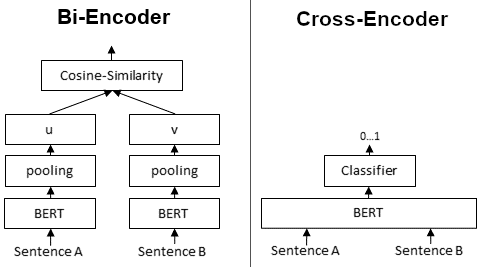

In [ ]:
configuration = AlbertConfig()  # default parameters and configuration for ALBERT

## **Context Extraction**

In [5]:
# Your code here
def clean_data(data):
    message_list = data
    for i in range(len(message_list)):
        # Lower Case
        message = message_list[i].lower()

        # message = " ".join([word for word in message.split() if word.find('yes') == -1])
        # message = " ".join([word for word in message.split() if word.find('no') == -1])
        
        message = " ".join(message.split())

        message_list[i] = message

    return message_list

### **Train**

In [6]:
df_con = pd.read_csv('/content/drive/MyDrive/univai/Project/faq_context.csv')

In [7]:
df_con.head()

,Unnamed: 0,Title,Context,Question,Answer,Unnamed: 2,Unnamed: 3
0,0,Pre-class,The course schedule may include readings in th...,Are session pre-class quizzes graded?,No. Pre-class quiz is to just check your under...,NaN,NaN
1,1,Deadlines,The exercises that you worked on during the ma...,When is the deadline for the submission of ses...,5 PM on the day of the following lecture.,NaN,NaN
2,2,Deadlines,The exercises that you worked on during the ma...,Will there be any extension allowed for the qu...,Only for exceptional cases.,NaN,NaN
3,3,Amount of work,Our courses need a time commitment of about 15...,How many hours will I need to dedicate to succ...,About 15 hours per week.,NaN,NaN
4,4,Exercise grading,We conduct both group and individual evaluatio...,Who will grade my exercise?,The exercises are auto-graded once you click t...,NaN,NaN


In [8]:
# The possibel contexts
contexts = df_con.Context.tolist()
contexts = clean_data(contexts)

In [9]:
train_questions = df_con.Question.tolist()
train_questions = clean_data(train_questions)

In [10]:
train_answers = df_con.Answer.tolist()
train_answers = clean_data(train_answers)

In [11]:
# The pretrained cross encoder model is loaded, with maximum length set at 512
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)

In [12]:
# The score is found for each question against each context vector, the highest score context vector is chosen then for that question.
train_contexts = []
for question in train_questions:
  que_cont = [(question, text) for text in contexts]
  scores = model.predict(que_cont)
  ind = np.argmax(scores)
  train_contexts.append(contexts[ind])

In [13]:
# Finding the start index for the answer if available in the context, , if not found ind is set at 0
train_start_indexes = []
no_ans = 0
for context, answer in zip(train_contexts, train_answers):
  ind = context.find(answer[:20])
  if ind == -1:
    ind = context.find(answer[:5])
  if ind == -1:
    ind = 0
    no_ans += 1
  train_start_indexes.append(ind)

In [14]:
# Number of questions out of 33 of whom we coudnt find the answer start idx in the automatically found context
no_ans

15

### **Test**

In [15]:
import pandas as pd
df_test = pd.read_csv('/content/drive/MyDrive/univai/Project/test_manual.csv')

In [16]:
df_test.head()

,Questions,Context,start_idx,end_idx
0,Will the pre-class session be recorded?,The course schedule may include readings in th...,0,2
1,What is the deadline for quiz submission?,The exercises that you worked on during the ma...,0,2
2,What is the deadline for exercise submission?,The exercises that you worked on during the ma...,0,2
3,How many hours do I need to complete this course?,Our courses need a time commitment of about 15...,0,2
4,Who will grade the exercise?,We conduct both group and individual evaluatio...,0,2


In [17]:
val_questions = df_test.Questions.tolist()
val_questions = clean_data(val_questions)

# The possible contexts
contexts = df_con.Context.tolist()
contexts = clean_data(contexts)

# Dummy answers and start_idx for ease of pre-processing
val_answers = ['No Provided Answer']*len(val_questions)

val_start_idx = df_test.start_idx.tolist()

In [18]:
# The pretrained cross encoder model is loaded, with maximum length set at 512
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)

In [19]:
# The score is found for each question against each context vector, the highest score context vector is chosen then for that question.
val_contexts = []
for question in val_questions:
  que_cont = [(question, text) for text in contexts]
  scores = model.predict(que_cont)
  ind = np.argmax(scores)
  val_contexts.append(contexts[ind])

## Load Tokenizer & Preprocess the data

1. Go through the JSON file and store every record as a SquadExample object.
2. Go through each SquadExample and create x_train, y_train, x_eval, y_eval.


In [ ]:
max_len = 384 # The maximum length is set as 384

In [20]:
tokenizer = AlbertTokenizerFast.from_pretrained('albert-large-v2')

In [21]:
# SquadExample class is used for making an object for each question in SQuAD
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer(context, return_offsets_mapping=True)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, start_end in enumerate(tokenized_context['offset_mapping']):
            start = start_end[0]
            end = start_end[1]
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer(question, return_offsets_mapping=True)

        # Create inputs
        input_ids = tokenized_context['input_ids'] + tokenized_question['input_ids'][1:]
        token_type_ids = [0] * len(tokenized_context['input_ids']) + [1] * len(
            tokenized_question['input_ids'][1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context['offset_mapping']


def create_squad_examples(clean_questions, clean_context, clean_answers, start_indexes):
    squad_examples = []
   
    for ques, cont, ans, idx in zip(clean_questions, clean_context, clean_answers, start_indexes):
      question = ques
      context = cont
      answer_text = ans
      start_char_idx = idx
      squad_eg = SquadExample(
          question, context, start_char_idx, answer_text
      )
      squad_eg.preprocess()
      squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y


train_squad_examples = create_squad_examples(train_questions, train_contexts, train_answers, train_start_indexes)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(val_questions, val_contexts, val_answers, val_start_idx)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")


33 training points created.
24 evaluation points created.


## **Model Maker** 

Create the Question-Answering Model using BERT and Functional API


In [23]:

def create_model():
    ## Pretrained ALBERT encoder
    encoder = TFAlbertModel.from_pretrained("albert-large-v2")

    ## QA Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    # Getting the Contextual EMbeddings from ALBERT
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]
    # Initializing the embedding of ALBERT from the fine-tuned weights of SQuAD
    embedding_model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=embedding,
    )

    embedding_model.load_weights('/content/drive/MyDrive/univai/Project/squad_model.h5')

    # The probability for identifying the start index of the attention span
    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
    start_logits = layers.Flatten()(start_logits)

    # The probability for identifying the end index of the attention span
    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
    end_logits = layers.Flatten()(end_logits)

    # Softmax is applied for getting the probabilities
    start_probs = layers.Activation(keras.activations.softmax)(start_logits)
    end_probs = layers.Activation(keras.activations.softmax)(end_logits)

    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[start_probs, end_probs],
    )
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss=[loss, loss], metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')])
    # model.load_weights('/content/drive/MyDrive/univai/Project/squad_whole_model.h5')
    return model, embedding_model



We advise this notebook to be run on Google Colab TPU runtime.
With Colab TPUs, each epoch will take 1 second.


In [24]:
use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model, embedding_model = create_model()
else:
    model, embedding_model = create_model()

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.78.167.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.78.167.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at albert-large-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-large-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
tf_albert_model (TFAlbertModel) TFBaseModelOutputWit 17683968    input_1[0][0]                    
                                                                 input_3[0][0]              

In [26]:
# For fine-tuning the ALBERT model on the small UNIV-AI dataset we'll be initializing the weights for the ALBERT embeddings from the 
#above trained SQuAD model and freeze them, only the dense layer for getting the probabilities of start and end token is trained.
albert_layer = model.get_layer('tf_albert_model')
albert_layer.trainable = False

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
tf_albert_model (TFAlbertModel) TFBaseModelOutputWit 17683968    input_1[0][0]                    
                                                                 input_3[0][0]              

## Create evaluation Callback

This callback will will save the a CSV file containing the question and it's predicted answer for each epoch.


In [28]:
from collections import Counter
def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text


class Predicted_Ans(keras.callbacks.Callback):

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        predicted_answers = []
        questions = []
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalize_text(pred_ans)

            questions.append(normalize_text(squad_eg.question))
            predicted_answers.append(normalized_pred_ans)

        df_dict = {'Question' : questions, 'Answer' : predicted_answers}
        df = pd.DataFrame(df_dict, columns=['Question','Answer'])
        if epoch%1 == 0:
          df.to_csv('/content/drive/MyDrive/univai/Project/Univ_pred/auto_predicted_albert' + str(epoch) + '.csv', index=False)



## Train and Evaluate


In [29]:
predicted_answers = Predicted_Ans(x_eval, y_eval)
model.fit(
    x_train,
    y_train,
    epochs=10,  # For demonstration, 3 epochs are recommended
    verbose=1,
    batch_size=33,
    callbacks=[predicted_answers],
)


Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=int64>]


1/1 [==============================] - 76s 76s/step - loss: 12.0311 - activation_loss: 5.6953 - activation_1_loss: 6.3358 - activation_accuracy: 0.1429 - activation_1_accuracy: 0.0000e+00


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 384) dtype=int64>]


Epoch 2/10
1/1 [==============================] - 0s 257ms/step - loss: 8.2067 - activation_loss: 3.5914 - activation_1_loss: 4.6153 - activation_accuracy: 0.6786 - activation_1_accuracy: 0.2857
Epoch 3/10
1/1 [==============================] - 0s 249ms/step - loss: 6.4834 - activation_loss: 2.6026 - activation_1_loss: 3.8808 - activation_accuracy: 0.9286 - activation_1_accuracy: 0.4286
Epoch 4/10
1/1 [==============================] - 0s 251ms/step - loss: 4.9896 - activation_loss: 1.5556 - activation_1_loss: 3.4341 - activation_accuracy: 0.9643 - activation_1_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 249ms/step - loss: 3.8897 - activation_loss: 0.8349 - activation_1_loss: 3.0548 - activation_accuracy: 1.0000 - activation_1_accuracy: 0.5357
Epoch 6/10
1/1 [==============================] - 0s 249ms/step - loss: 3.2078 - activation_loss: 0.5565 - activation_1_loss: 2.6513 - activation_accuracy: 1.0000 - activation_1_accuracy: 0.6786
Epoch 7/10
1/1 [=========

In [ ]:
# masked_texts = []
# for text in texts:
#   splitt = text.split()
#   num_mask = int(0.2*len(splitt))
#   rand_ind = np.random.randint(len(splitt), size = num_mask)
#   for ind in rand_ind:
#     splitt[ind] = '[MASK]'
#   masked_texts.append(" ".join(splitt))

# T5 (from HuggingFace Transformers) for Text Extraction

The abstract from the paper is the following:

Transfer learning, where a model is first pre-trained on a data-rich task before being fine-tuned on a downstream task, has emerged as a powerful technique in natural language processing (NLP). The effectiveness of transfer learning has given rise to a diversity of approaches, methodology, and practice. In this paper, we explore the landscape of transfer learning techniques for NLP by introducing a unified framework that converts every language problem into a text-to-text format. Our systematic study compares pretraining objectives, architectures, unlabeled datasets, transfer approaches, and other factors on dozens of language understanding tasks. By combining the insights from our exploration with scale and our new “Colossal Clean Crawled Corpus”, we achieve state-of-the-art results on many benchmarks covering summarization, question answering, text classification, and more. To facilitate future work on transfer learning for NLP, we release our dataset, pre-trained models, and code.

So basically T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and the best pretraining methods were used after various trials. In T5 each task is converted into a text-to-text format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….

## Introduction to Datset & Training Method

This demonstration uses SQuAD (Stanford Question-Answering Dataset).
In SQuAD, an input consists of a question, and a paragraph for context.
The goal is to find the span of text in the paragraph that answers the question.
We evaluate our performance on this data with the "Exact Match" metric,
which measures the percentage of predictions that exactly match any one of the
ground-truth answers.

We fine-tune a T5 model to perform this task as follows:

1. Feed the context and the question as inputs to T5 encoder and the answer  the right shifted answer to the decoder input.
2. The embeddings from the decoder are taken and sent through a dense softmax layer, with units equal to the vocab of T5 tokenizer.


**References:**

- [T5](https://arxiv.org/abs/1910.10683)
- [SQuAD](https://arxiv.org/abs/1606.05250)


# **Fine Tuning on Squad**


In [6]:
max_len = 384
configuration = T5Config()  # default parameters and configuration for BERT

## Load the data


In [7]:
# load train and validation split of squad
train_dataset = load_dataset('squad', split='train')
valid_dataset = load_dataset('squad', split='validation')

# train_dataset.features

Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/4fffa6cf76083860f85fa83486ec3028e7e32c342c218ff2a620fc6b2868483a)
Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/4fffa6cf76083860f85fa83486ec3028e7e32c342c218ff2a620fc6b2868483a)


In [8]:
tokenizer = T5TokenizerFast.from_pretrained('t5-base')

In [9]:
encoder_max_len = 250
decoder_max_len = 25 
global_counter = 0

In [10]:
def encode(example, encoder_max_len= 250, decoder_max_len = 25, bool_obj = True):
    if global_counter == 1:
      bool_obj = False
    # print(bool_obj)
    context = example['context']
    question = example['question']
    answer = example['answers']['text']
  
    question_plus = f"answer_me: {str(question)}"
    context_plus = f"context: {str(context)}"
    
    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"<pad> {answer_plus}"
    
    encoder_inputs = tokenizer(question_plus, context_plus, truncation=bool_obj, max_length=encoder_max_len, pad_to_max_length=bool_obj)
    
    decoder_inputs = tokenizer(answer_plus, truncation=bool_obj, max_length=decoder_max_len, pad_to_max_length=bool_obj)
    
    input_ids = encoder_inputs['input_ids']
    input_attention = encoder_inputs['attention_mask']
    target_ids = decoder_inputs['input_ids']
    target_attention = decoder_inputs['attention_mask']
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'decoder_input_ids':target_ids, 'decoder_attention_mask':target_attention}
    return outputs

In [11]:
# map add_eos_to_examples function to the dataset example wise 
train_ds=  train_dataset.map(encode)
global_counter = 1
valid_ds=  valid_dataset.map(encode)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [12]:
x_train = [np.array(train_ds['input_ids']), np.array(train_ds['attention_mask']), np.array(train_ds['decoder_input_ids'])[:, :-1], np.array(train_ds['decoder_attention_mask'])[:, :-1]]
y_train = np.array(train_ds['decoder_input_ids'])[:, 1:]

x_eval = [valid_ds['input_ids'], valid_ds['attention_mask']]
y_eval = valid_ds['decoder_input_ids']

In [13]:
# x_train[2][x_train[2] == 0] = -100

In [14]:
# y_train[y_train == 0] = -100

In [15]:
x_train[0].shape

(87599, 250)

In [16]:
x_train[3][17]

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [17]:
len(y_eval)

10570

In [18]:
# configuration.learni

## **Model Maker** 

Create the Question-Answering Model using BERT and Functional API


In [19]:

def create_model():
    ## BERT encoder
    encoder = TFT5Model.from_pretrained("t5-base")

    ## QA Model
    input_ids = layers.Input(shape=(None,), dtype=tf.int32)
    decoder_input_ids = layers.Input(shape=(None,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(None,), dtype=tf.int32)
    decoder_attention_mask = layers.Input(shape=(None,), dtype=tf.int32)
    embedding = encoder(input_ids  = input_ids, decoder_input_ids =decoder_input_ids, attention_mask=attention_mask, decoder_attention_mask = decoder_attention_mask)[0]

    embedding_model = keras.Model(
        inputs=[input_ids, attention_mask, decoder_input_ids, decoder_attention_mask],
        outputs=embedding,
    )

    # embedding_model.load_weights('/content/drive/MyDrive/univai/Project/T5_emb_model.h5')

    qa_head = layers.Dense(configuration.vocab_size, name="qa_head", activation = 'softmax')(embedding)

    model = keras.Model(
        inputs=[input_ids, attention_mask, decoder_input_ids, decoder_attention_mask],
        outputs=qa_head)
    
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss=[loss, loss], metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')])
    # model.load_weights('/content/drive/MyDrive/univai/Project/T5_model.h5')
    return model, embedding_model

# def create_model():
#   return TFMT5ForConditionalGeneration.from_pretrained("google/mt5-small")

This code should preferably be run on Google Colab TPU runtime.
With Colab TPUs, each epoch will take 5-6 minutes.


In [20]:
use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model, embedding_model = create_model()
else:
    model, embedding_model = create_model()

model.summary()


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.109.240.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.109.240.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFT5Model.

All the layers of TFT5Model were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5Model for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
# for layer in encoder.layers:
#   for weight in layer.weights:
#     print(weight.name)

In [22]:
configuration.tie_word_embeddings

True

## Create evaluation Callback

This callback will compute the exact match score using the validation data
after every epoch.


In [23]:
MAX_LENGTH = 16

In [24]:
########################################
# search strategy: temperature (re-shape)
########################################
def temperature(logits, temperature):
        probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
        return probs


########################################
# search strategy: nucleus (truncate)
########################################
def nucleus(probs, p):
    
    probs /= sum(probs)
    sorted_probs = np.sort(probs)[::-1]
    sorted_index = np.argsort(probs)[::-1]
    cusum_sorted_probs = np.cumsum(sorted_probs)
    after_threshold = cusum_sorted_probs > p
    if sum(after_threshold) > 0:
        last_index = np.where(after_threshold)[0][-1]
        candi_index = sorted_index[:last_index]
    else:
        candi_index = sorted_index[:3] # just assign a value
    candi_probs = [probs[i] for i in candi_index]
    candi_probs /= sum(candi_probs)
    word = np.random.choice(candi_index, size=1, p=candi_probs)[0]
  
    return word

In [25]:
def evaluate(sentence):
  input_ids = np.array(sentence[0]).reshape(1,-1)
  attention_mask = np.array(sentence[1]).reshape(1,-1)
  decoder_data = tokenizer("<pad>")
  decoder_data = {'input_ids' : decoder_data['input_ids'][:-1], 'attention_mask' : decoder_data['attention_mask'][:-1]}
  decoder_input_ids = np.array(decoder_data['input_ids']).reshape(1,-1)
  decoder_attention_mask = np.array(decoder_data['attention_mask']).reshape(1,-1)

  for i in range(MAX_LENGTH):
    predictions = model.predict([input_ids, attention_mask, decoder_input_ids, decoder_attention_mask])

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]#.reshape(-1)
    predicted_id = np.argmax(predictions, axis=-1)
    # probs = temperature(logits=predictions, temperature=1.0)
    # predicted_id = nucleus(probs=probs, p=0.90)
    predicted_id = predicted_id[0][0]

    # return the result if the predicted_id is equal to the end token
    if predicted_id == 1:
      break

    # concatenated the predicted_id to the output which is given to the decoder as its input.
    decoder_input_ids = np.append(decoder_input_ids.reshape(-1), np.array([predicted_id])).reshape(1,-1)
    decoder_attention_mask = np.ones((1, decoder_input_ids.shape[1]))
    # print(decoder_input_ids)

  return decoder_input_ids

def predict(sentence):
  prediction = evaluate(sentence)
  predicted_sentence = tokenizer.decode([i for i in prediction[0] if i < tokenizer.vocab_size])
  return predicted_sentence

In [26]:
# evaluate()

In [27]:
from collections import Counter
import re

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        # print(ground_truth)
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)

def test_metrics(sentences, ground_truths):
  f1 = exact_match = total = 0

  for i, ground_truth in tqdm(enumerate(ground_truths)):
    sentence = [sentences[0][i], sentences[1][i]]
    total += 1
    prediction = predict(sentence)
    gt = tokenizer.decode([i for i in ground_truth if i != 1])
    gt = gt.split(',')
    temp = gt[0].split()
    gt[0] = temp[0]
    gt.insert(1, ' ' + " ".join(temp[1:]))
    gt = [gt[0] + gt[i] for i in range(1,len(gt))]
    exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, gt)
    f1 += metric_max_over_ground_truths(
          f1_score, prediction, gt)
    print('\nReal : ',gt)
    print('Pred : ', prediction)

  exact_match = 100.0 * exact_match / total
  f1 = 100.0 * f1 / total

  return {'exact_match': exact_match, 'f1': f1}

In [28]:
tokenizer.decode([i for i in y_eval[0] if i != 1])

'<pad> Denver Broncos, Denver Broncos, Denver Broncos'

## Train and Evaluate


In [29]:
# exact_match_callback = ExactMatch(x_eval, y_eval)
model.fit(
    x_train,
    y_train,
    epochs=3,  # For demonstration, 3 epochs are recommended
    verbose=1,
    batch_size=16,
    validation_split = 0.1
    # validation_data = (x_eval, y_eval),
    # callbacks=[exact_match_callback],
)


Epoch 1/3


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 25) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 25) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None, 25) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 25) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 25) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None, 25) dtype=int64>]


4928/4928 [==============================] - ETA: 0s - loss: 1.8287 - accuracy: 0.8318

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 250) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 25) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 25) dtype=int64>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None, 25) dtype=int64>]


4928/4928 [==============================] - 802s 135ms/step - loss: 1.8287 - accuracy: 0.8318 - val_loss: 1.2531 - val_accuracy: 0.8589
Epoch 2/3
4928/4928 [==============================] - 641s 130ms/step - loss: 1.0588 - accuracy: 0.8817 - val_loss: 0.7637 - val_accuracy: 0.9192
Epoch 3/3
4928/4928 [==============================] - 641s 130ms/step - loss: 0.6081 - accuracy: 0.9439 - val_loss: 0.4095 - val_accuracy: 0.9642


In [30]:
# embedding_model.save_weights('/content/drive/MyDrive/univai/Project/T5_emb_model2.h5')

In [31]:
# model.save_weights('/content/drive/MyDrive/univai/Project/T5_model2.h5')

In [ ]:
y_eval.shape

NameError: ignored

In [ ]:
metrics = test_metrics(x_eval, y_eval)

In [ ]:
metrics

In [ ]:
x_train[0].shape

In [ ]:
preds = model.predict(x_eval[:2])

In [ ]:
preds

In [ ]:
# x_eval

In [ ]:
start = np.argmax(preds[0], axis = -1)
end = np.argmax(preds[1], axis = -1)

In [ ]:
ind = 150

In [ ]:
start[ind]

In [ ]:
end[ind]

In [ ]:
y_eval[0][ind]

In [ ]:
y_eval[1][ind]

In [ ]:
x_train

In [ ]:
y_train

In [ ]:
xxxx = tokenizer(["hello my name is arjun", 'jingalala hoo haa'], ["What is your name", 'jhghj fhg hh'], truncation=True, padding=True, return_tensors = 'np', max_length=max_len, return_offsets_mapping=True)

In [ ]:
xxxx['offset_mapping'][0][0]

In [ ]:
tokenizer.decode(xxxx['input_ids'][0])

In [ ]:
val_contexts

In [ ]:
val_encodings

# **Fine Tuning on Univ AI(With Manual Context)**


In [30]:
configuration = T5Config()  # default parameters and configuration for BERT

In [37]:
tokenizer.pad_token_id

0

## Load the data


In [7]:
# Your code here
def clean_data(data):
    message_list = data
    for i in range(len(message_list)):
        # Lower Case
        message = message_list[i].lower()
        
        message = " ".join(message.split())

        message_list[i] = message

    return message_list

In [8]:
df_con = pd.read_csv('/content/drive/MyDrive/univai/Project/faq_context.csv')

In [9]:
df_con.head()

,Unnamed: 0,Title,Context,Question,Answer,Unnamed: 2,Unnamed: 3
0,0,Pre-class,The course schedule may include readings in th...,Are session pre-class quizzes graded?,No. Pre-class quiz is to just check your under...,NaN,NaN
1,1,Deadlines,The exercises that you worked on during the ma...,When is the deadline for the submission of ses...,5 PM on the day of the following lecture.,NaN,NaN
2,2,Deadlines,The exercises that you worked on during the ma...,Will there be any extension allowed for the qu...,Only for exceptional cases.,NaN,NaN
3,3,Amount of work,Our courses need a time commitment of about 15...,How many hours will I need to dedicate to succ...,About 15 hours per week.,NaN,NaN
4,4,Exercise grading,We conduct both group and individual evaluatio...,Who will grade my exercise?,The exercises are auto-graded once you click t...,NaN,NaN


In [10]:
questions_list = df_con.Question.tolist()
train_questions = clean_data(questions_list)

In [11]:
answer_list = df_con.Answer.tolist()
train_answers = clean_data(answer_list)

In [12]:
context_list = df_con.Context.tolist()
train_contexts = clean_data(context_list)

In [13]:
import pandas as pd
df_test = pd.read_csv('/content/drive/MyDrive/univai/Project/test_manual.csv')

In [14]:
df_test.head()

,Questions,Context,start_idx,end_idx
0,Will the pre-class session be recorded?,The course schedule may include readings in th...,0,2
1,What is the deadline for quiz submission?,The exercises that you worked on during the ma...,0,2
2,What is the deadline for exercise submission?,The exercises that you worked on during the ma...,0,2
3,How many hours do I need to complete this course?,Our courses need a time commitment of about 15...,0,2
4,Who will grade the exercise?,We conduct both group and individual evaluatio...,0,2


In [15]:
val_questions = df_test.Questions.tolist()
val_questions = clean_data(val_questions)

val_answers = ['No Provided Answer']*len(val_questions)

val_contexts = df_test.Context.tolist()
val_contexts = clean_data(val_contexts)

## Preprocess the data

1. Go through the JSON file and store every record as a `SquadExample` object.
2. Go through each `SquadExample` and create `x_train, y_train, x_eval, y_eval`.


In [16]:
tokenizer = T5TokenizerFast.from_pretrained('t5-base')

In [17]:
def preprocess(context, question, answer):
    question_plus = f"answer_me: {str(question)}"
    context_plus = f"context: {str(context)}"
    
    answer_plus = f"<pad>{str(answer)}"

    return [question_plus, context_plus, answer_plus]

In [18]:
ind = 0
for context, question, answer in tqdm(zip(train_contexts, train_questions, train_answers)):
  listt = preprocess(context, question, answer)
  train_questions[ind] = listt[0]
  train_contexts[ind] = listt[1]
  train_answers[ind] = listt[2]
  ind += 1

33it [00:00, 87992.39it/s]


In [19]:
enocder_train_inputs = tokenizer(train_questions, train_contexts, pad_to_max_length=True, padding = True)
decoder_train_inputs = tokenizer(train_answers, pad_to_max_length=True, padding = True)

In [20]:
ind = 0
for context, question, answer in tqdm(zip(val_contexts, val_questions, val_answers)):
  listt = preprocess(context, question, answer)
  val_questions[ind] = listt[0]
  val_contexts[ind] = listt[1]
  val_answers[ind] = listt[2]
  ind += 1

24it [00:00, 87609.48it/s]


In [21]:
enocder_val_inputs = tokenizer(val_questions, val_contexts)

In [22]:
x_train = [np.array(enocder_train_inputs['input_ids']), np.array(enocder_train_inputs['attention_mask']), np.array(decoder_train_inputs['input_ids'])[:, :-1], np.array(decoder_train_inputs['input_ids'])[:, :-1]]
y_train = np.array(decoder_train_inputs['input_ids'])[:, 1:]

x_eval = [enocder_val_inputs['input_ids'], enocder_val_inputs['attention_mask']]

In [23]:
x_train[2][0]

array([    0,   150,     5,   554,    18,  4057, 20967,    19,    12,
         131,   691,    39,  1705,    13,     8,  1183,     5,    34,
          56,    59,  3476,  1587,    39,  2769,     5,     1,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

In [26]:
y_train[0]

array([  150,     5,   554,    18,  4057, 20967,    19,    12,   131,
         691,    39,  1705,    13,     8,  1183,     5,    34,    56,
          59,  3476,  1587,    39,  2769,     5,     1,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

In [27]:
# x_train[2][x_train[2] == 0] = -100

In [26]:
# y_train[y_train == 0] = -100

## **Model Maker** 

Create the Question-Answering Model using BERT and Functional API


In [31]:

def create_model():
    ## BERT encoder
    encoder = TFT5Model.from_pretrained("t5-base")

    ## QA Model
    input_ids = layers.Input(shape=(None,), dtype=tf.int32)
    decoder_input_ids = layers.Input(shape=(None,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(None,), dtype=tf.int32)
    decoder_attention_mask = layers.Input(shape=(None,), dtype=tf.int32)
    embedding = encoder(input_ids  = input_ids, decoder_input_ids =decoder_input_ids, attention_mask=attention_mask, decoder_attention_mask = decoder_attention_mask)[0]

    embedding_model = keras.Model(
        inputs=[input_ids, attention_mask, decoder_input_ids, decoder_attention_mask],
        outputs=embedding,
    )

    embedding_model.load_weights('/content/drive/MyDrive/univai/Project/T5_emb_model.h5')

    qa_head = layers.Dense(configuration.vocab_size, name="qa_head", activation = 'softmax')(embedding)

    model = keras.Model(
        inputs=[input_ids, attention_mask, decoder_input_ids, decoder_attention_mask],
        outputs=qa_head)
    
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss=[loss, loss], metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')])
    # model.load_weights('/content/drive/MyDrive/univai/Project/T5_univ_man_model.h5')
    return model, embedding_model

# def create_model():
#   return TFMT5ForConditionalGeneration.from_pretrained("google/mt5-small")

This code should preferably be run on Google Colab TPU runtime.
With Colab TPUs, each epoch will take 5-6 minutes.


In [32]:
use_tpu = False
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model, embedding_model = create_model()
else:
    model, embedding_model = create_model()



All model checkpoint layers were used when initializing TFT5Model.

All the layers of TFT5Model were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5Model for predictions without further training.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [34]:
t5_layer = model.get_layer('tf_t5model_1')
t5_layer.trainable = False

In [35]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## Create evaluation Callback

This callback will compute the exact match score using the validation data
after every epoch.


In [36]:
MAX_LENGTH = 50

In [37]:

########################################
# search strategy: temperature (re-shape)
########################################
def temperature(logits, temperature):
        probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
        return probs


########################################
# search strategy: nucleus (truncate)
########################################
def nucleus(probs, p):
    
    probs /= sum(probs)
    sorted_probs = np.sort(probs)[::-1]
    sorted_index = np.argsort(probs)[::-1]
    cusum_sorted_probs = np.cumsum(sorted_probs)
    after_threshold = cusum_sorted_probs > p
    if sum(after_threshold) > 0:
        last_index = np.where(after_threshold)[0][-1]
        candi_index = sorted_index[:last_index]
    else:
        candi_index = sorted_index[:3] # just assign a value
    candi_probs = [probs[i] for i in candi_index]
    candi_probs /= sum(candi_probs)
    word = np.random.choice(candi_index, size=1, p=candi_probs)[0]
  
    return word

In [38]:
def evaluate(sentence):
  input_ids = np.array(sentence[0]).reshape(1,-1)
  attention_mask = np.array(sentence[1]).reshape(1,-1)
  decoder_data = tokenizer("<pad>")
  decoder_data = {'input_ids' : decoder_data['input_ids'][:-1], 'attention_mask' : decoder_data['attention_mask'][:-1]}
  decoder_input_ids = np.array(decoder_data['input_ids']).reshape(1,-1)
  decoder_attention_mask = np.array(decoder_data['attention_mask']).reshape(1,-1)

  for i in range(MAX_LENGTH):
    predictions = model.predict([input_ids, attention_mask, decoder_input_ids, decoder_attention_mask])

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]#.reshape(-1)
    predicted_id = np.argmax(predictions, axis=-1)
    # probs = temperature(logits=predictions, temperature=1.0)
    # predicted_id = nucleus(probs=probs, p=0.90)
    predicted_id = predicted_id[0][0]

    # return the result if the predicted_id is equal to the end token
    if predicted_id == 1:
      break

    # concatenated the predicted_id to the output which is given to the decoder as its input.
    decoder_input_ids = np.append(decoder_input_ids.reshape(-1), np.array([predicted_id])).reshape(1,-1)
    decoder_attention_mask = np.ones((1, decoder_input_ids.shape[1]))
    # print(decoder_input_ids)

  return decoder_input_ids

def predict(sentence):
  prediction = evaluate(sentence)
  predicted_sentence = tokenizer.decode([i for i in prediction[0] if i < tokenizer.vocab_size])
  return predicted_sentence

In [39]:
# evaluate()

## Train and Evaluate


In [40]:
model.fit(
    x_train,
    y_train,
    epochs=50,  # For demonstration, 3 epochs are recommended
    verbose=1,
    batch_size=33,
    validation_split = 0.1
)

Epoch 1/50
1/1 [==============================] - 52s 52s/step - loss: 10.2362 - accuracy: 0.0000e+00 - val_loss: 10.0637 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 13s 13s/step - loss: 10.1584 - accuracy: 0.0000e+00 - val_loss: 9.9699 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 12s 12s/step - loss: 10.0373 - accuracy: 0.0017 - val_loss: 9.8767 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 13s 13s/step - loss: 9.9645 - accuracy: 0.0164 - val_loss: 9.7839 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 12s 12s/step - loss: 9.8635 - accuracy: 0.0531 - val_loss: 9.6916 - val_accuracy: 0.3770
Epoch 6/50
1/1 [==============================] - 13s 13s/step - loss: 9.7674 - accuracy: 0.1668 - val_loss: 9.6020 - val_accuracy: 0.3852
Epoch 7/50
1/1 [==============================] - 13s 13s/step - loss: 9.6693 - accuracy: 0.3109 - val_loss: 9.5116 - val_accuracy: 0.6967

KeyboardInterrupt: ignored

In [ ]:
# embedding_model.save_weights('/content/drive/MyDrive/univai/Project/T5_emb_model.h5')

In [38]:
model.save_weights('/content/drive/MyDrive/univai/Project/T5_univ_man_model.h5')

In [37]:
len(x_eval)

2

In [35]:
predicted_answers = []
for i in range(24):
  pred_sent = predict([x_eval[0][i], x_eval[1][i]])
  predicted_answers.append(pred_sent)
  print(pred_sent)
df_dict = {'Questions' : val_questions, 'Answers' : predicted_answers}
df = pd.DataFrame(df_dict, columns=['Question','Answer'])
df.to_csv('/content/drive/MyDrive/univai/Project/Univ_pred/manual_predicted_T5.csv', index=False)

<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


KeyboardInterrupt: ignored

In [107]:
df = pd.DataFrame(df_dict)
df.to_csv('/content/drive/MyDrive/univai/Project/Univ_pred/manual_predicted_T5.csv', index=False)
df

,Questions,Answers
0,answer_me: will the pre-class session be recor...,<pad> yes.
1,answer_me: what is the deadline for quiz submi...,<pad> yes.
2,answer_me: what is the deadline for exercise s...,<pad> yes.
3,answer_me: how many hours do i need to complet...,<pad> yes theaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
4,answer_me: who will grade the exercise?,<pad> yes.
5,answer_me: why is the auto-grader failing me?,<pad> yes.
6,answer_me: do i do the exercises individually?,<pad> individually.
7,answer_me: is the lab compulsory?,<pad> yes.
8,answer_me: will the sessions be recorded?,<pad> yes.
9,answer_me: can i have access to the recorded v...,<pad> yes.
